In [6]:
!pip install torch torchvision captum quantus grad-cam
import pathlib
import random
import copy
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import models
from captum.attr import *
import quantus
from pytorch_grad_cam import GradCAMPlusPlus
from captum.attr import LRP
from captum.attr._utils.lrp_rules import EpsilonRule, GammaRule, Alpha1_Beta0_Rule

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 50.6 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 14.7 MB/s eta 0:00:00
  Created wheel for grad-cam: filename=grad_cam-1.5.0-py3-none-any.whl size=38071 sha256=544e5660f86d5878d7ab16d11d087e4e8587361ab026ef102b98af45959c30f8
  Stored in directory: /root/.cache/pip/wheels/5b/e5/3d/8548241d5cffe53ad1476c566a61ad9bf09cc61a9430f09726
Successfully built grad-cam


2024-05-20 06:37:08.963171: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-20 06:37:08.963318: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-20 06:37:09.128049: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [64]:
import json
!wget -P '/content' https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
labels_path = '/content/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2024-05-20 07:09:04--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.202.136, 54.231.168.176, 52.217.66.198, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.202.136|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: '/content/imagenet_class_index.json'

imagenet_class_inde 100%[===================>]  34.53K   182KB/s    in 0.2s    

2024-05-20 07:09:05 (182 KB/s) - '/content/imagenet_class_index.json' saved [35363/35363]



In [65]:
idx_to_labels['1']

['n01443537', 'goldfish']

In [8]:
# Adjust this path.
path_to_files = "/kaggle/input/imagenet-dataset"

# Load test data and make loaders.
x_batch = torch.load(f'{path_to_files}/x_batch.pt')
y_batch = torch.load(f'{path_to_files}/y_batch.pt')
s_batch = torch.load(f'{path_to_files}/s_batch.pt')
s_batch = s_batch.unsqueeze(dim=1)
print(f"{len(x_batch)} matches found.")

17 matches found.


In [9]:
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 129MB/s]  


In [15]:
from pytorch_grad_cam import GradCAMPlusPlus
cam = GradCAMPlusPlus(model=model, target_layers=[model.features[-1]])
grayscale_cam = cam(input_tensor=x_batch)

In [25]:
layers = list(model._modules["features"]) + list(model._modules["classifier"])
num_layers = len(layers)

for idx_layer in range(1, num_layers):
    if idx_layer <= 30:
        setattr(layers[idx_layer], "rule", Alpha1_Beta0_Rule())
    elif idx_layer >= 31:
        setattr(layers[idx_layer], "rule", EpsilonRule(epsilon=0))
lrp = LRP(model)
attributions_lrp = lrp.attribute(x_batch, target=y_batch)
attributions_lrp_np = attributions_lrp.cpu().detach().numpy()
attributions_lrp_np = np.transpose(attributions_lrp_np, (0,2,3,1))
attributions_lrp_np = np.average(attributions_lrp_np, axis=3)
attributions_lrp_np = (attributions_lrp_np.T/np.max(attributions_lrp_np, axis=(1,2)).T).T

/opt/conda/lib/python3.10/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


In [26]:
grayscale_cam_thr = np.copy(grayscale_cam)
grayscale_cam_thr = grayscale_cam_thr - 0.2
grayscale_cam_thr = np.clip(grayscale_cam_thr, 0, 1)
product = attributions_lrp_np * grayscale_cam_thr
product = (product.T / np.max(product, axis=(1,2)).T).T

In [61]:
import cv2
smoothed = np.zeros(product.shape)
for i in range(0, product.shape[0]):
    smoothed[i] = cv2.GaussianBlur(product[i],(5,5),cv2.BORDER_DEFAULT)
    smoothed[i] = smoothed[i] / np.max(smoothed[i])

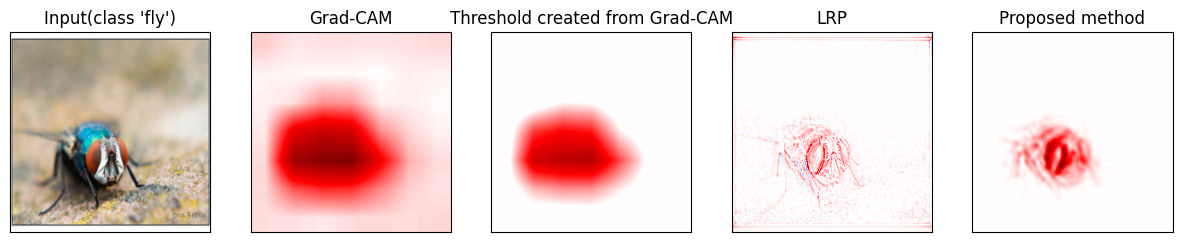

In [81]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 4.5))
axes[0].imshow(np.moveaxis(quantus.normalise_func.denormalise(x_batch[1].cpu().detach().numpy(), mean=np.array([0.485, 0.456, 0.406]), std=np.array([0.229, 0.224, 0.225])), 0, -1), vmin=0.0, vmax=1.0)
axes[0].title.set_text("Input(class 'fly')")
axes[1].imshow(grayscale_cam[1], cmap="seismic", vmin=-1.0, vmax=1.0)
axes[1].title.set_text("Grad-CAM")
axes[2].imshow(grayscale_cam_thr[1], cmap="seismic", vmin=-1.0, vmax=1.0)
axes[2].title.set_text("Threshold created from Grad-CAM")
axes[3].imshow(attributions_lrp_np[1], cmap="seismic", vmin=-1.0, vmax=1.0)
axes[3].title.set_text("LRP")
axes[4].imshow(smoothed[1], cmap="seismic", vmin=-1.0, vmax=1.0)
axes[4].title.set_text("Proposed method")
for i in range(0, 5):
    axes[i].axis("on")
    axes[i].get_xaxis().set_ticks([])
    axes[i].get_yaxis().set_ticks([])
plt.savefig('/kaggle/working/example.png', bbox_inches='tight')

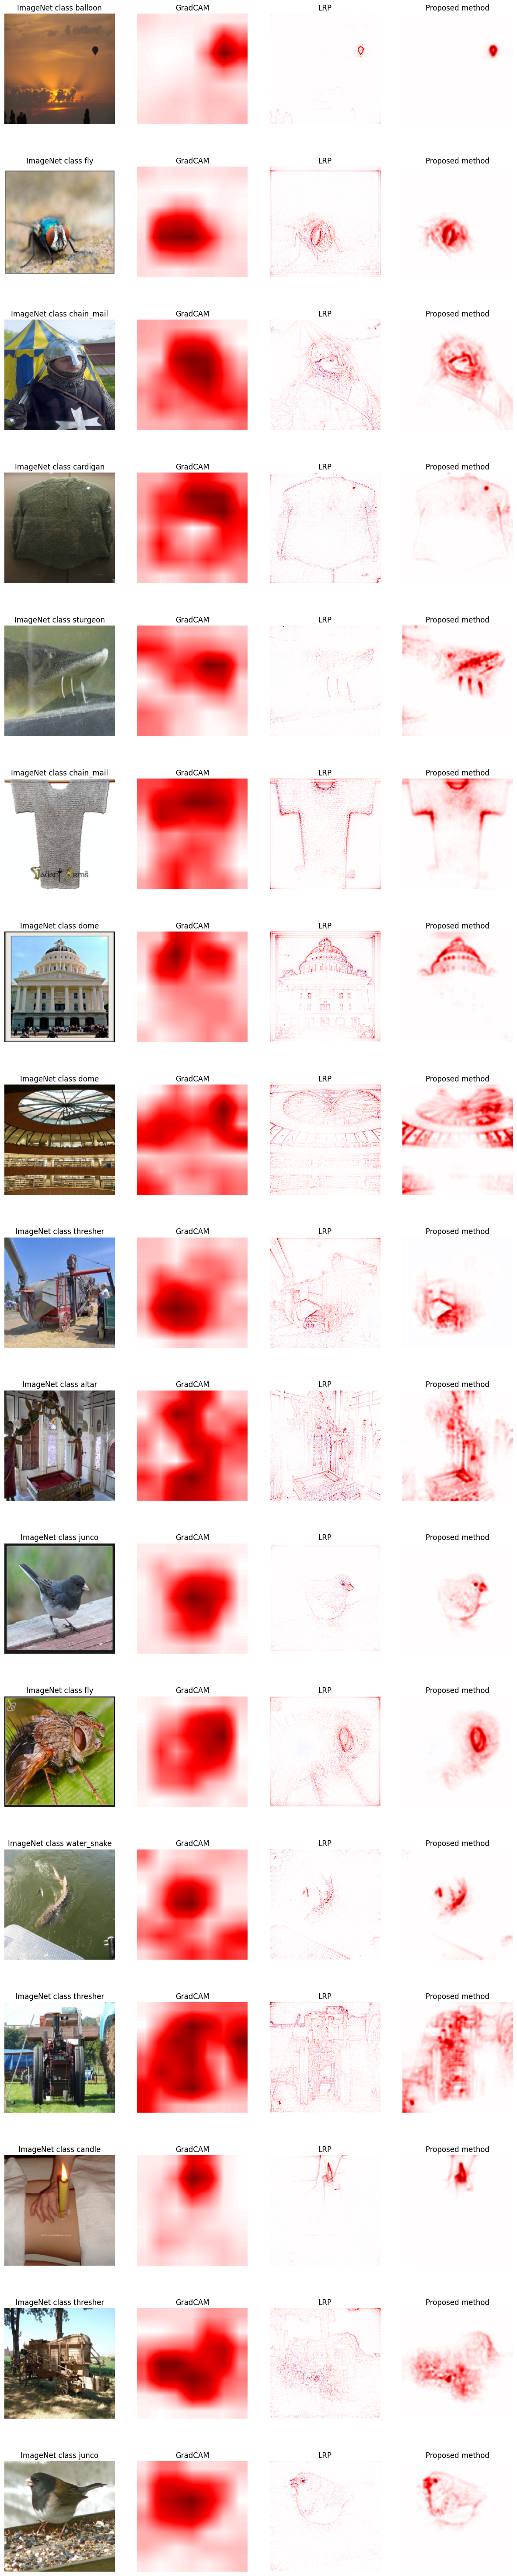

In [66]:
explanations = {
    "GradCAM": grayscale_cam,
    "LRP": attributions_lrp_np,
    "Proposed method": smoothed
}
fig, axes = plt.subplots(nrows=len(x_batch), ncols=1+len(explanations), figsize=(15, 4.5*len(x_batch)))
for index in range(0, len(x_batch)):
    axes[index][0].imshow(np.moveaxis(quantus.normalise_func.denormalise(x_batch[index].cpu().detach().numpy(), mean=np.array([0.485, 0.456, 0.406]), std=np.array([0.229, 0.224, 0.225])), 0, -1), vmin=0.0, vmax=1.0)
    axes[index][0].title.set_text(f"ImageNet class {idx_to_labels[str(y_batch[index].item())][1]}")
    axes[index][0].axis("off"); 
    for i, (k, v) in enumerate(explanations.items()):
        axes[index][i+1].imshow(explanations[k][index]/np.max(explanations[k][index]), cmap="seismic", vmin=-1.0, vmax=1.0)
        axes[index][i+1].title.set_text(f"{k}")
        axes[index][i+1].axis("off");
plt.savefig('/kaggle/working/qualitative.png', bbox_inches='tight')

In [86]:
from captum.metrics import infidelity

noise = torch.tensor(np.random.normal(0, 0.003, (170, 3, 224, 224))).float()

def perturb_fn(inputs):
   return noise, inputs - noise

infid = infidelity(model, perturb_fn, x_batch, attributions_lrp, normalize=True, target=y_batch)
print(infid)

tensor([0.0024, 0.0030, 0.0015, 0.0017, 0.0014, 0.0195, 0.0004, 0.0003, 0.0008,
        0.0005, 0.0065, 0.0017, 0.0007, 0.0007, 0.0012, 0.0004, 0.0076])


In [90]:
grayscale_cam_rp = np.repeat(grayscale_cam, 3)
grayscale_cam_rp = grayscale_cam_rp.reshape((17,224,224,3))
grayscale_cam_rp = np.transpose(grayscale_cam_rp, (0,3,1,2))
grayscale_cam_rp = torch.tensor(grayscale_cam_rp)

infid_gcam = infidelity(model, perturb_fn, x_batch, grayscale_cam_rp, normalize=True, target=y_batch)
print(infid_gcam)

tensor([0.0026, 0.0036, 0.0017, 0.0016, 0.0014, 0.0159, 0.0003, 0.0003, 0.0007,
        0.0005, 0.0062, 0.0020, 0.0007, 0.0009, 0.0011, 0.0008, 0.0076])


In [92]:
smoothed_rp = np.repeat(smoothed, 3)
smoothed_rp = smoothed_rp.reshape((17,224,224,3))
smoothed_rp = np.transpose(smoothed_rp, (0,3,1,2))
smoothed_rp = torch.tensor(smoothed_rp)

infid_smoothed = infidelity(model, perturb_fn, x_batch, smoothed_rp, normalize=True, target=y_batch)
print(infid_smoothed)

tensor([0.0035, 0.0034, 0.0017, 0.0017, 0.0014, 0.0118, 0.0004, 0.0003, 0.0008,
        0.0005, 0.0064, 0.0020, 0.0007, 0.0008, 0.0012, 0.0008, 0.0058],
       dtype=torch.float64)


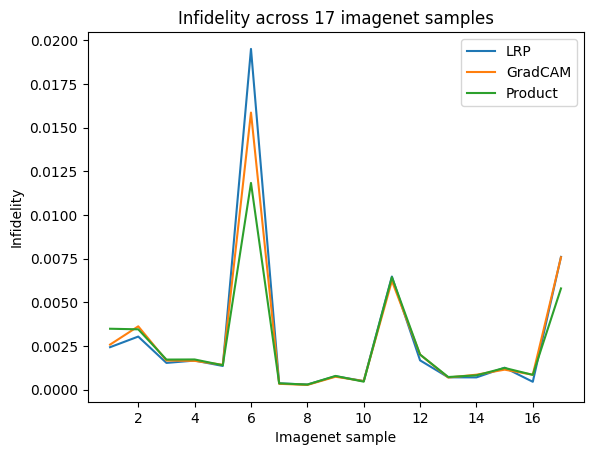

In [93]:
x = np.arange(1, 18)
fig, ax = plt.subplots()
ax.plot(x, infid, label='LRP')
ax.plot(x, infid_gcam, label='GradCAM')
ax.plot(x, infid_smoothed, label='Product')

# Adding a legend
ax.legend()
ax.set_xlabel('Imagenet sample')
ax.set_ylabel('Infidelity')
ax.set_title('Infidelity across 17 imagenet samples')
plt.savefig('/kaggle/working/infedility_graph.png', bbox_inches='tight')

In [116]:
import cv2
cam = GradCAMPlusPlus(model=model, target_layers=[model.features[-1]])
lrp = LRP(model)
def explainer_wrapper(model, inputs, targets, **kwargs) -> np.ndarray:
    """Wrapper for explainer functions."""
    inputs = torch.tensor(inputs)
    targets = torch.tensor(targets)
    global cam
    global lrp
    if kwargs["method"] == "GradCAM":
        grayscale_cam = cam(input_tensor=inputs)
        grayscale_cam = (grayscale_cam.T / np.max(grayscale_cam, axis=(1,2)).T).T
        grayscale_cam = np.expand_dims(grayscale_cam, axis=(1))
        return grayscale_cam
    elif kwargs["method"] == "LRP":
        attributions_lrp = lrp.attribute(inputs, target=targets)
        attributions_lrp_np = attributions_lrp.cpu().detach().numpy()
        attributions_lrp_np = np.average(attributions_lrp_np, axis=1)
        attributions_lrp_np = (attributions_lrp_np.T / np.max(attributions_lrp_np, axis=(1,2)).T).T
        attributions_lrp_np = np.expand_dims(attributions_lrp_np, axis=(1))    
        return attributions_lrp_np
    elif kwargs["method"] == "Proposed_method":
        cam = GradCAMPlusPlus(model=model, target_layers=[model.features[-1]])
        grayscale_cam = cam(input_tensor=inputs)
        grayscale_cam = grayscale_cam - 0.2
        grayscale_cam = np.clip(grayscale_cam, 0, 1)
        
        attributions_lrp = lrp.attribute(inputs, target=targets)
        attributions_lrp_np = attributions_lrp.cpu().detach().numpy()
        attributions_lrp_np = np.average(attributions_lrp_np, axis=1)
        
        product = attributions_lrp_np * grayscale_cam
        for i in range(0, product.shape[0]):
            product[i] = cv2.GaussianBlur(product[i],(5,5),cv2.BORDER_DEFAULT)
        product = (product.T / np.max(product, axis=(1,2)).T).T
        
        product = np.expand_dims(product, axis=(1))
        return product
    else:
        raise ValueError("Pick an explanation function that exists.")

In [145]:
# Define XAI methods and metrics.
xai_methods = ['Proposed_method', 'GradCAM', 'LRP']
metrics = {
    "Robustness": quantus.AvgSensitivity(
        nr_samples=10,
        lower_bound=0.2,
        norm_numerator=quantus.norm_func.fro_norm,
        norm_denominator=quantus.norm_func.fro_norm,
        perturb_func=quantus.perturb_func.uniform_noise,
        similarity_func=quantus.similarity_func.difference,
        abs=False,
        normalise=False,
        aggregate_func=np.mean,
        return_aggregate=True,
        disable_warnings=True,
    ),
    "Faithfulness": quantus.FaithfulnessCorrelation(
        nr_runs=10,
        subset_size=224,
        perturb_baseline="uniform",
        perturb_func=quantus.perturb_func.baseline_replacement_by_indices,
        similarity_func=quantus.similarity_func.correlation_pearson,
        abs=False,
        normalise=False,
        aggregate_func=np.mean,
        return_aggregate=True,
        disable_warnings=True,
    ),
    "Localisation": quantus.RelevanceRankAccuracy(
        abs=False,
        normalise=False,
        aggregate_func=np.mean,
        return_aggregate=True,
        disable_warnings=True,
    ),
    "Complexity": quantus.Sparseness(
        abs=True,
        normalise=False,
        aggregate_func=np.mean,
        return_aggregate=True,
        disable_warnings=True,
    ),
    "Randomisation": quantus.RandomLogit(
        num_classes=1000,
        similarity_func=quantus.similarity_func.ssim,
        abs=True,
        normalise=False,
        aggregate_func=np.mean,
        return_aggregate=True,
        disable_warnings=True,
    ),
}

In [ ]:
model.eval()

In [ ]:
results = {method : {} for method in xai_methods}

for method in xai_methods:
    for metric, metric_func in metrics.items():
        print(f"Evaluating {metric} of {method} method.")
        scores = metric_func(
            model=model,
            x_batch=x_batch.cpu().detach().numpy(),
            y_batch=y_batch.cpu().detach().numpy(),
            a_batch=None,
            s_batch=s_batch.cpu().detach().numpy(),
            explain_func=explainer_wrapper,
            explain_func_kwargs={
                "method": method,
            },
        )
        results[method][metric] = scores

In [143]:
results

{'Proposed_method': {'Robustness': [1.1652683647239908],
  'Faithfulness': [0.03734115217269317],
  'Localisation': [0.5597855206242422],
  'Complexity': [0.8355333692117959],
  'Randomisation': [0.8061996960163201]},
 'LRP': {'Robustness': [1.3242623276570262],
  'Faithfulness': [0.08189723259246846],
  'Localisation': [0.5183895941301451],
  'Complexity': [0.6286554573455696],
  'Randomisation': [0.6353618720947013]},
 'GradCAM': {'Robustness': [0.215785616811584],
  'Faithfulness': [0.03481853313621857],
  'Localisation': [0.7458860212511745],
  'Complexity': [0.42190169451331144],
  'Randomisation': [1.000000001552227]}}

In [146]:
# Postprocessing of scores: to get how the different explanation methods rank across criteria.
import numpy as np
import pandas as pd
results_agg = {}
for method in xai_methods:
    results_agg[method] = {}
    for metric, metric_func in metrics.items():
        results_agg[method][metric] = np.mean(results[method][metric])

df = pd.DataFrame.from_dict(results_agg)
df = df.T.abs()

# Take inverse ranking for Robustness, since lower is better.
df_normalised = df.loc[:, df.columns != 'Robustness'].apply(lambda x: x / x.max())
df_normalised["Robustness"] = df["Robustness"].min()/df["Robustness"].values
df_normalised_rank = df_normalised.rank()
df_normalised_rank

Faithfulness  Localisation  Complexity  Randomisation  \
Proposed_method           2.0           2.0         3.0            2.0   
GradCAM                   1.0           3.0         1.0            3.0   
LRP                       3.0           1.0         2.0            1.0   

                 Robustness  
Proposed_method         2.0  
GradCAM                 3.0  
LRP                     1.0

In [147]:
df

Robustness  Faithfulness  Localisation  Complexity  \
Proposed_method    1.165268      0.037341      0.559786    0.835533   
GradCAM            0.215786      0.034819      0.745886    0.421902   
LRP                1.324262      0.081897      0.518390    0.628655   

                 Randomisation  
Proposed_method       0.806200  
GradCAM               1.000000  
LRP                   0.635362

In [154]:
df.to_csv('quantus_results.csv')

In [149]:
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

In [150]:
def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.
    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default."""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default."""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels, angles=None):
            self.set_thetagrids(angles=np.degrees(theta), labels=labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

        def draw(self, renderer):
            """ Draw. If frame is polygon, make gridlines polygon-shaped."""
            if frame == 'polygon':
                gridlines = self.yaxis.get_gridlines()
                for gl in gridlines:
                    gl.get_path()._interpolation_steps = num_vars
            super().draw(renderer)


        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)

                return {'polar': spine}
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

In [152]:
import seaborn as sns
sns.set()
# Plotting configs.
sns.set(font_scale=1.8)
plt.style.use('seaborn-v0_8-white')
plt.rcParams['ytick.labelleft'] = True
plt.rcParams['xtick.labelbottom'] = True

include_titles = True
include_legend = True

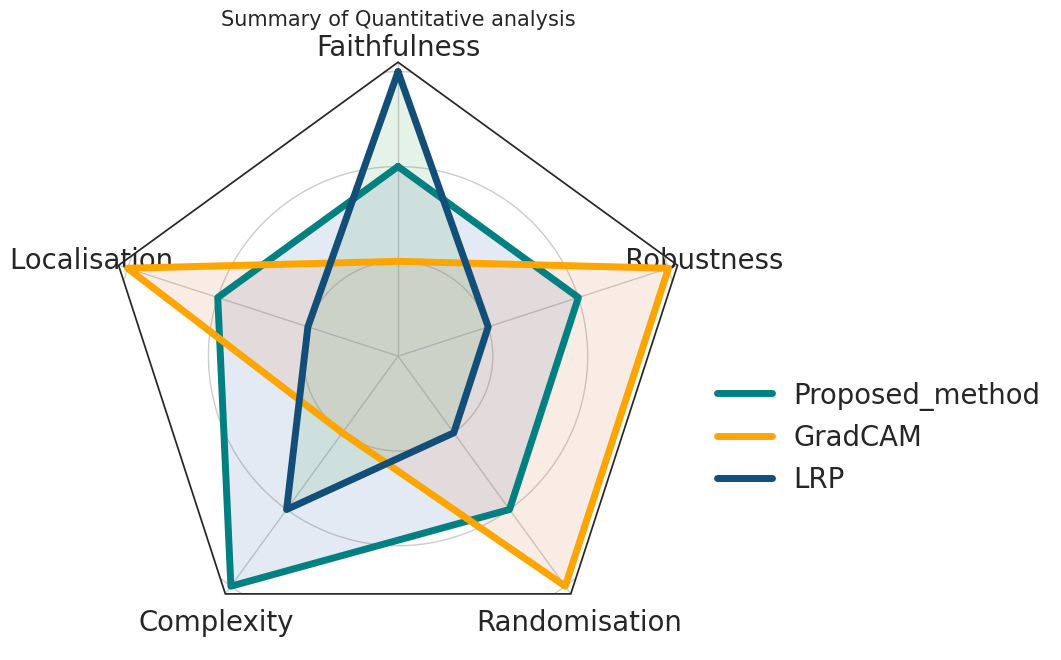

In [153]:
# Make spyder graph!
colours_order = ["#008080", "#FFA500", "#124E78", "#d62728"]
data = [df_normalised_rank.columns.values, (df_normalised_rank.to_numpy())]
theta = radar_factory(len(data[0]), frame='polygon')
spoke_labels = data.pop(0)

fig, ax = plt.subplots(figsize=(11, 11), subplot_kw=dict(projection='radar'))
fig.subplots_adjust(top=0.85, bottom=0.05)
for i, (d, method) in enumerate(zip(data[0], xai_methods)):
    line = ax.plot(theta, d, label=method, color=colours_order[i], linewidth=5.0)
    ax.fill(theta, d, alpha=0.15)

# Set lables.
if include_titles:
    ax.set_varlabels(labels=['Faithfulness', 'Localisation   ', '\nComplexity', '\nRandomisation', '   Robustness'])
else:
    ax.set_varlabels(labels=[]) 

ax.set_rgrids(np.arange(0, df_normalised_rank.values.max() + 0.5), labels=[]) 

# Set a title.
ax.set_title("Summary of Quantitative analysis",  position=(0.5, 1.1), ha='center', fontsize=15)

# Put a legend to the right of the current axis.
if include_legend:
    ax.legend(loc='upper left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig('/kaggle/working/my_figure.png', bbox_inches='tight')